# 資優生策略

In [1]:
import pandas as pd

def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()

def mystrategy2(data):
    
    股本 = data.get('股本合計', 1)#.drop_duplicates(['stock_id', 'date'], keep='last')#.pivot(index='date', columns='stock_id')
    price = data.get('收盤價', 200)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    rsv = (price.iloc[-1] - price.iloc[-150:].min()) / (price.iloc[-150:].max() - price.iloc[-150:].min())
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    condition6 = rsv > 0.5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5 & condition6
    
    return select_stock[select_stock]


In [9]:
from strategies.strategy import strategy
from finlab.data import Data

data = Data()
strategy(data)

stock_id
1109    True
1451    True
1454    True
1558    True
1582    True
2597    True
2614    True
3501    True
4536    True
4927    True
4942    True
5288    True
6108    True
6192    True
6442    True
8070    True
8213    True
8497    True
dtype: bool

# 檢查報酬率

2018-09-01 - 2018-10-31 報酬率: -11.94 % nstock 32
2018-10-31 - 2018-12-30 報酬率: 0.46 % nstock 10
每次換手最大報酬 : 0.46 ％
每次換手最少報酬 : -11.94 ％


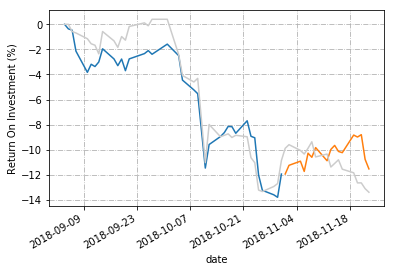

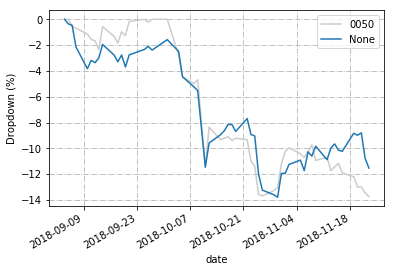

(2018-09-04    1.000000
 2018-09-05    0.996374
 2018-09-06    0.995338
 2018-09-07    0.978586
 2018-09-10    0.961704
 2018-09-11    0.968142
 2018-09-12    0.966330
 2018-09-13    0.969952
 2018-09-14    0.980476
 2018-09-17    0.972378
 2018-09-18    0.967032
 2018-09-19    0.972300
 2018-09-20    0.963034
 2018-09-21    0.972412
 2018-09-25    0.976638
 2018-09-26    0.979026
 2018-09-27    0.976116
 2018-10-01    0.984198
 2018-10-04    0.975021
 2018-10-05    0.955506
 2018-10-08    0.947669
 2018-10-09    0.944682
 2018-10-11    0.885372
 2018-10-12    0.904137
 2018-10-15    0.910535
 2018-10-16    0.913654
 2018-10-17    0.918536
 2018-10-18    0.918397
 2018-10-19    0.913105
 2018-10-22    0.923090
 2018-10-23    0.910727
 2018-10-24    0.909520
 2018-10-25    0.879849
 2018-10-26    0.867622
 2018-10-29    0.864051
 2018-10-30    0.862063
 2018-10-31    0.880623
 2018-11-01    0.880623
 2018-11-02    0.887563
 2018-11-05    0.890867
 2018-11-06    0.882689
 2018-11-07    0

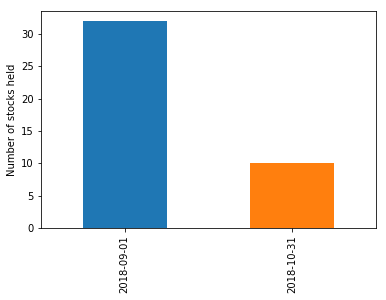

In [5]:
# 起手式
from finlab.backtest import backtest
from finlab.data import Data
import datetime
%matplotlib inline

# 回測
data = Data()
backtest(datetime.date(2018,9,1), datetime.date(2018,11,23), 60, mystrategy2, data)

# 更新持股投資張數

In [7]:
from finlab.backtest import portfolio

data = Data()

# 利用 mystrategy2 來產生股票清單 stocks
stocks = mystrategy2(data)

# 用portfolio來幫忙計算，給定 500000 元，依照今天收盤價，股票張數要如何分配
p, total_invest_money = portfolio(stocks.index, 500000, data, add_cost=10)

# 印出股票資訊
print('---------------')
print('|  portfolio  |')
print('---------------')
print(p)
print('total cost')
print(total_invest_money)

estimate price according to 2018-11-23 00:00:00
initial number of stock 18
after considering fee 18
after considering 1000 share 10
---------------
|  portfolio  |
---------------
stock_id
1109    3.0
1451    1.0
1454    6.0
2597    1.0
2614    3.0
4927    1.0
4942    1.0
6108    1.0
6442    1.0
8213    1.0
Name: 2018-11-23 00:00:00, dtype: float64
total cost
356870.0
